In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
SEED = 20240302

torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [4]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.47MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.2MB/s]


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 🔴 10 CLASS

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [7]:
model = FashionCNN()


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
for epoch in range(10):
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Accuracy: {correct/total:.4f}")


Epoch 1, Accuracy: 0.8140
Epoch 2, Accuracy: 0.8737
Epoch 3, Accuracy: 0.8928
Epoch 4, Accuracy: 0.9041
Epoch 5, Accuracy: 0.9112
Epoch 6, Accuracy: 0.9185
Epoch 7, Accuracy: 0.9238
Epoch 8, Accuracy: 0.9304
Epoch 9, Accuracy: 0.9320
Epoch 10, Accuracy: 0.9358


In [10]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Test Accuracy:", correct/total)


Test Accuracy: 0.91


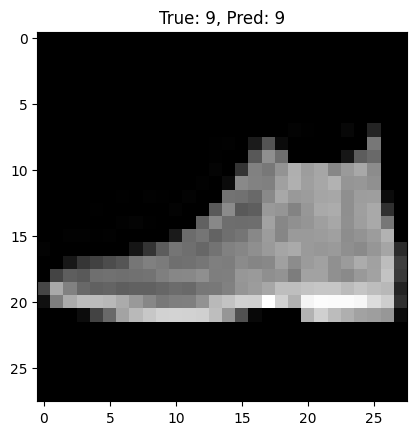

In [11]:
images, labels = next(iter(test_loader))
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"True: {labels[0]}, Pred: {preds[0]}")
plt.show()


In [12]:
model_v2 = FashionCNN()
model_v2.dropout = nn.Dropout(0.3)

criterion = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.001)


In [13]:
train_acc_v2 = []

for epoch in range(10):
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer_v2.zero_grad()
        outputs = model_v2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_v2.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    train_acc_v2.append(acc)
    print(f"Epoch {epoch+1}, Accuracy: {acc:.4f}")


Epoch 1, Accuracy: 0.8311
Epoch 2, Accuracy: 0.8886
Epoch 3, Accuracy: 0.9040
Epoch 4, Accuracy: 0.9155
Epoch 5, Accuracy: 0.9237
Epoch 6, Accuracy: 0.9299
Epoch 7, Accuracy: 0.9362
Epoch 8, Accuracy: 0.9413
Epoch 9, Accuracy: 0.9443
Epoch 10, Accuracy: 0.9494


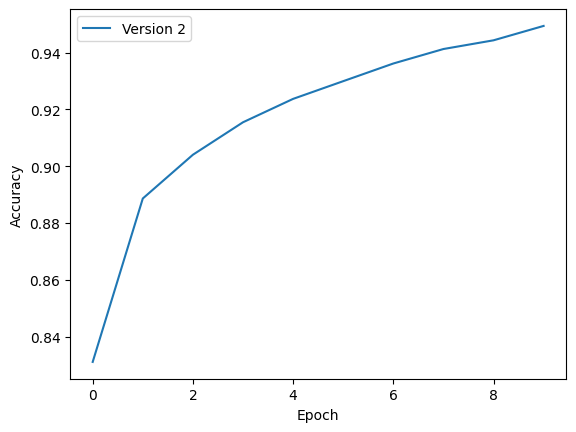

In [14]:
plt.plot(train_acc_v2, label="Version 2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [16]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model   # Version 1
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_v1 = correct / total
print("Version 1 Test Accuracy:", acc_v1)



Version 1 Test Accuracy: 0.9124


In [17]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_v2(images)   # Version 2
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc_v2 = correct / total
print("Version 2 Test Accuracy:", acc_v2)


Version 2 Test Accuracy: 0.9066


In [18]:
if acc_v2 > acc_v1:
    best_model = model_v2
    print("Best model: Version 2")
else:
    best_model = model
    print("Best model: Version 1")


Best model: Version 1


In [19]:
all_preds = []
all_labels = []


In [20]:
best_model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())


In [21]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[889   0  17   7   2   1  80   0   4   0]
 [  2 982   0  10   1   0   4   0   1   0]
 [ 16   1 909   4  39   0  31   0   0   0]
 [ 31   1  13 908  18   0  29   0   0   0]
 [  2   0  46  22 890   0  40   0   0   0]
 [  0   0   0   0   0 991   0   7   0   2]
 [121   0  65  24  70   0 711   0   9   0]
 [  0   0   0   0   0  11   0 967   0  22]
 [  4   1   1   3   3   1   2   1 984   0]
 [  0   0   0   0   0   5   0  23   1 971]]


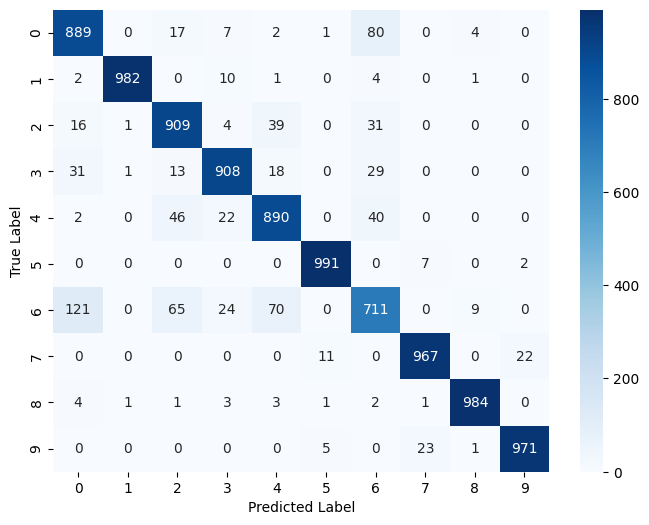

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [23]:
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [25]:
images, labels = next(iter(test_loader))
best_model.eval()

with torch.no_grad():
    outputs = best_model(images)
    _, preds = torch.max(outputs, 1)



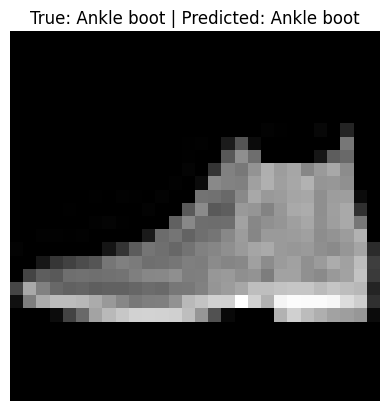

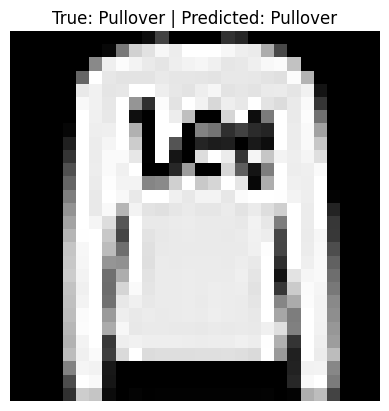

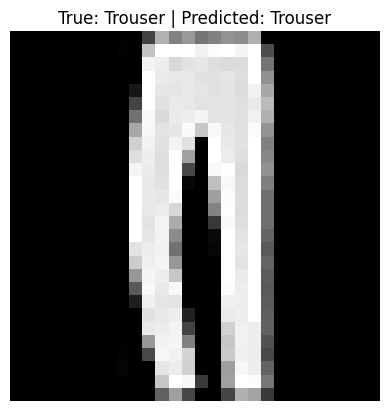

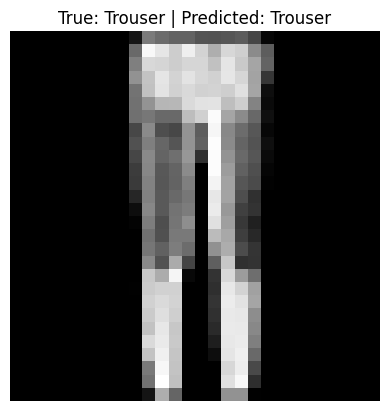

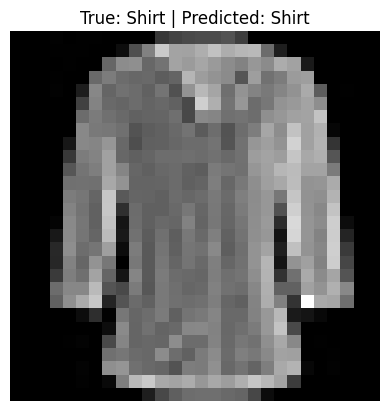

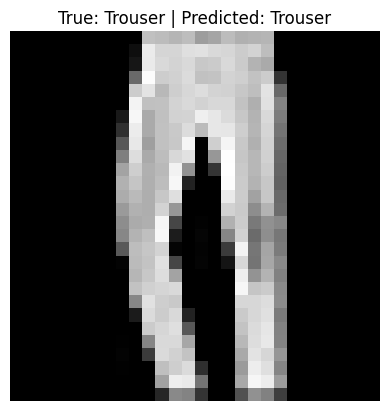

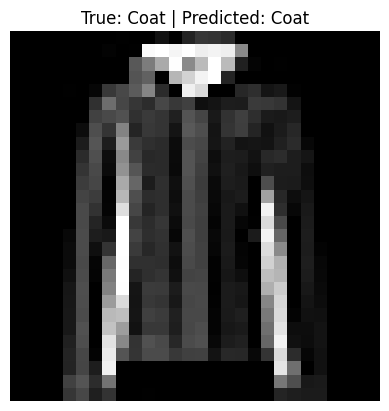

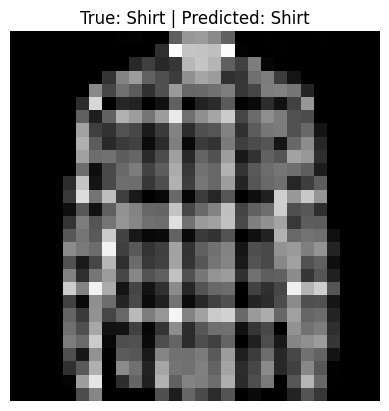

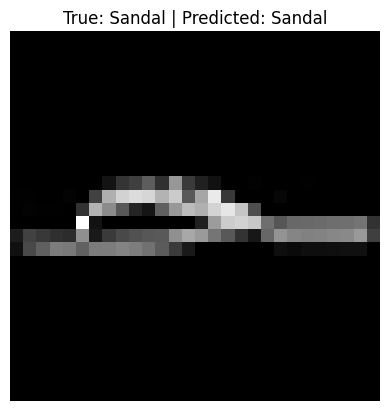

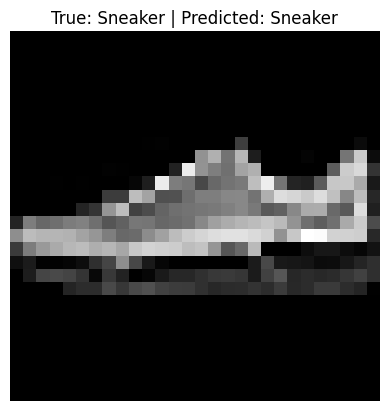

In [26]:
for i in range(10):
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(
        f"True: {classes[labels[i]]} | Predicted: {classes[preds[i]]}"
    )
    plt.axis("off")
    plt.show()


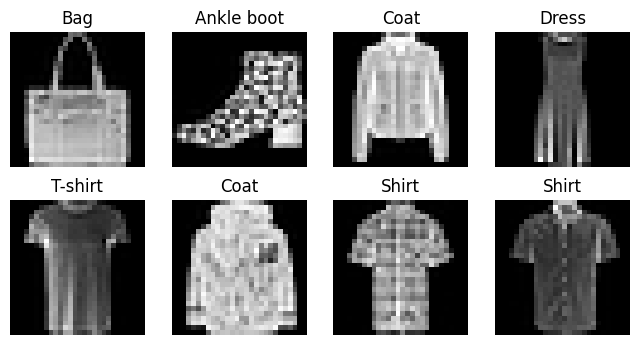

In [27]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.show()
